In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn.decomposition as skdec

from skimage.io import imread
import scipy

import matplotlib.animation as animation
from IPython.display import HTML

import sys
import os
from pytictoc import TicToc
import matplotlib
import pickle

from skimage import filters, morphology

rootff = ''
sys.path.append(rootff+'/SpeckledFluoImagingAnalisys/')

import speckle_stuffs as spkstf
from moro_utils import eprint
import h5py

In [3]:
datasources = {
    '43nm':rootff+'/04042019/video_04042019_1270', 
    '10nm':rootff+'/04042019/video_04042019_5809',
}

actual_bw = '43nm'
datasource = datasources[actual_bw]

try:
    video_real = np.swapaxes(scipy.io.loadmat(datasource+'_speckle.mat')['video_data_top'], 0, 2)
    raise Exception('All variable loading has not been implement yet...')
except NotImplementedError:
    import h5py
    video_real = np.array(h5py.File(datasource+'_speckle.mat')['video_data_top'])
    ptno_data = np.array(h5py.File(datasource+'_spotsno.mat')['ptno_data']) 
    beads_pos = np.array(h5py.File(datasource+'_spotspos.mat')['beads_pos'])

In [55]:
# calculate the mask on the filtered video
video_filt = spkstf.gauss_don_filt_GPU(video_real, hp=1.5, lp=400)

In [56]:
from skimage.measure import label, regionprops
from skimage.morphology import disk, opening, closing
from skimage.filters import threshold_otsu, rank

mean_filt = np.mean(video_filt, axis=0)
mean_filt = mean_filt/np.max(mean_filt)


threshold_global_otsu = threshold_otsu(mean_filt)
global_otsu = mean_filt >= threshold_global_otsu

# open and close
global_mask = opening(global_otsu, disk(10))
global_mask = closing(global_mask, disk(10))

# remove borders
border_mask = np.zeros_like(global_mask)
border_mask[:,0] = 1; border_mask[:,-1] = 1; border_mask[0,:] = 1; border_mask[-1,:] = 1;
global_label = label(global_mask)
for bordersidx in np.unique(border_mask*global_label):
    global_label[global_label==bordersidx] = 0

# indicize again the labels
global_label = label(global_label>0)
# find tghe largest region (probably the center)
centralareaidx = np.argmax([rr.area for rr in regionprops(global_label)])+1
central_area_mask = global_label==centralareaidx

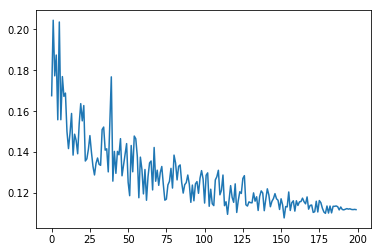

In [60]:
import numpy.ma as ma
contrasts = np.array([])

# for frame in video_filt:
for frame in video_real:
    masked_frame = ma.masked_array(frame, ~central_area_mask)
    contrasts = np.append(contrasts, np.std(masked_frame)/np.mean(masked_frame))
plt.plot(contrasts)

In [ ]:
# grouped by 10 (have been taken 10 measurements for every set of beads)

beads_ticks = range(20)
beads_ctr = [np.mean(contrasts[i*10:(i*10)+10]) for i in range(20)]
beads_ctr_sem = [np.std(contrasts[i*10:(i*10)+10])/np.sqrt(10-1) for i in range(20)]
plt.errorbar(beads_ticks, beads_ctr, beads_ctr_sem)
plt.show()

In [62]:
# dataset_43 = [beads_ticks, beads_ctr, beads_ctr_sem]
dataset_10 = [beads_ticks, beads_ctr, beads_ctr_sem]

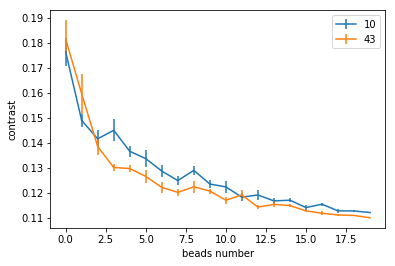

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(dataset_10[0], dataset_10[1], dataset_10[2], label='10')
ax.errorbar(dataset_43[0], dataset_43[1], dataset_43[2], label='43')
ax.legend()
ax.set_xlabel('beads number')
ax.set_ylabel('contrast')
fig.show()

fig.savefig(rootff+'/two_contrast.eps',dpi=600)

In [7]:
# take a look at the quality of extracted datasets with bandwidth
root_folder = rootff+'/27952213613789/' # some bandwith changes (43, 10, 1)

pickles = [root_folder+ff for ff in os.listdir(root_folder) if ff.split('.')[-1]=='pickle']
df = pd.DataFrame(columns=['dataset','lowfilt','highfilt','alpha','l1 over l2','bit depth',\
                           'init', 'computing time', 'error_progression', 'correlation','correlation std'])

for picklesource in pickles:
    filehandler = open(picklesource, 'rb')
    [extr_traces, extr_footprints, dpars] = pickle.load(filehandler)
    filehandler.close()

    gt = rootff+picklesource.split('/')[-1].split('_')[1] + os.sep+ '_'.join((picklesource.split('/')[-1]).split('_')[:3])+'_gt.mat'                     
    grtrh_traces = spkstf.extract_traces_from_mat(gt)
    couplings = np.array(spkstf.find_trace_couplings(grtrh_traces, extr_traces))
    
    df = df.append({
        'dataset':picklesource,
        'components':dpars['components'],
        'lowfilt':dpars['lowfilter'],
        'highfilt':dpars['highfilter'],
        'binning':dpars['binning'],
        'correlation':np.mean(couplings[:,2]),
        'correlation std':np.std(couplings[:,2])
    }, ignore_index=True)

dft = df[['binning','dataset','components','correlation', 'correlation std']]
dft = dft[dft['binning']==20]
dft = dft[dft['dataset']!=rootff+'/27952213613789/data_08032019_003_27952213613789_1243076320645172.pickle']

In [4]:
import pandas as pd

# read as dataframes
dfFITC_em = pd.read_csv('FITC_em.txt', delimiter='\t', names=['wavelength', 'emission'])
dfFITC_em['emission'] /= np.max(dfFITC_em['emission'])

df43nm = pd.read_csv('MF530-43.csv')
df43nm.columns = ['wavelength', 'transmission']
df43nm['transmission'] /= 100

df10nm = pd.read_csv('FL05532-10_Rev2.csv', skiprows=1, dtype='float64')
df10nm.columns = ['wavelength', 'transmission', 'OD']
df10nm['transmission'] /= 100
df10nm = df10nm.sort_values('wavelength')
    
def multiply_spectras(emission_df, filter_df):
    merged = pd.merge_asof(filter_df, emission_df, on='wavelength')
    merged['emission'] = merged['transmission']*merged['emission']
    return merged[['wavelength', 'emission']].dropna()

bandwidths = ['10nm', '43nm']

emissions = {bw:multiply_spectras(dfFITC_em,filt) for filt, bw in zip([df10nm, df43nm], bandwidths)}

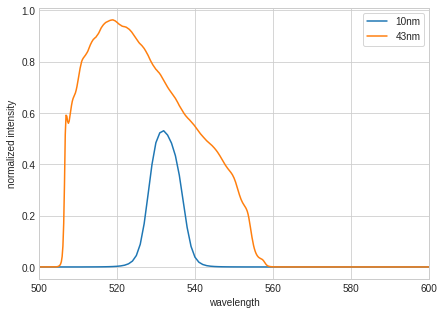

In [6]:
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([500, 600])
for bw in emissions.keys():
    plt.plot(emissions[bw]['wavelength'], emissions[bw]['emission'], label=bw)
plt.xlabel('wavelength')
plt.ylabel('normalized intensity')
plt.legend(frameon=True)

plt.show()